In [10]:
import numpy as np

from gbsio import read_from_csv
from partition import SSIPartitioner
from gbs import compute_unmarked_ssi, compute_marked_ssi
from gbs.ssi.utils import generate_background_points, auto_density

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from pyproj import Transformer
from cartopy.geodesic import Geodesic

In [66]:
def draw_ssi(data, centeridx=8, partitioner=None, radius=0.01, type='full'):
    if not partitioner:
        partitioner = SSIPartitioner(coords, k=400)
    i = centeridx
    center = data.get('coords')[i]
    presence_ids = partitioner.get_neighborhood(i, radius)
    presence_points = data.get('coords')[presence_ids]
    presence_values = data.get('values')[presence_ids]
    density = auto_density(radius, presence_points.shape[0])
    bg_points = generate_background_points(center, radius, density=density)

    marked_ssi = compute_marked_ssi(presence_points, presence_values, center, radius, density="auto", k=4)
    unmarked_ssi = compute_unmarked_ssi(presence_points, center, radius, density="auto", k=4)
    avg_acc = np.mean(np.where(presence_values<0, 0, presence_values))

    gdf_bg = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in np.degrees(bg_points)], crs="EPSG:4326")
    gdf_presence = gpd.GeoDataFrame(zip(presence_ids, presence_values), columns=['id', 'value'], geometry=[Point(lon, lat) for lat, lon in np.degrees(presence_points)], crs="EPSG:4326")
    gdf_presence_t = gdf_presence[gdf_presence['value']>0]
    gdf_presence_f = gdf_presence[gdf_presence['value']<0]

    marker_style_presence_t = dict(color='blue', marker='o', markersize=50,alpha=0.7, label='correct')
    marker_style_presence_f = dict(color='red', marker='o', markersize=50, alpha=0.7, label='incorrect')
    bg_markersize = {'full': 100, 'single': 20}
    marker_style_bg = dict(color='tab:grey',  marker='.', markersize=bg_markersize[type], label='background')

    if type=='full':

        # Function to generate a circle from lat/lon in radians
        def create_circle(lat_rad, lon_rad, radius, num_points=100):
            """
            Creates a circle (polygon) centered at (lat_rad, lon_rad) with radius in radians.
            """
            # Convert center point to degrees
            lat_deg = np.degrees(lat_rad)
            lon_deg = np.degrees(lon_rad)

            # Create a list to store the circle's points
            circle_points = []
            
            # Generate points around the circle
            for angle in np.linspace(0, 2 * np.pi, num_points):
                # Compute the new latitude/longitude using the radius
                new_lat = np.degrees(lat_rad + radius * np.sin(angle))
                new_lon = np.degrees(lon_rad + radius * np.cos(angle))
                circle_points.append((new_lon, new_lat))  # (lon, lat) format

            # Create a polygon from the generated circle points
            return Polygon(circle_points)

        def create_circle(lat_rad, lon_rad, radius, num_points=100):
            """
            Creates a circle (polygon) centered at (lat_rad, lon_rad) with radius in radians.
            """
            # Convert center point to degrees
            lat0 = np.degrees(lat_rad)
            lon0 = np.degrees(lon_rad)

            radius_m = radius * 6378137.0 # constant is from cartopy.geodesic

            # Create a list to store the circle's points
            gd = Geodesic()
            circle_points = gd.circle(lon0, lat0, radius_m, num_points) #63710 is the radius of Sphere (earth) in meters
            
            # Create a polygon from the generated circle points
            return Polygon(circle_points).boundary
        
        def calculate_line_length_km(line):
            """
            Calculate the geodesic length of a LineString in EPSG:4326 using pyproj.
            """
            transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
            
            # Transform the LineString to a projected coordinate system
            line_projected = LineString([transformer.transform(x, y) for x, y in line.coords])
            
            # Calculate length in meters and convert to km
            return round(line_projected.length / 1000)  # Convert meters to km

        # Define centerpoint in radians
        lat_rad_center, lon_rad_center = center   # Example longitude in radians (~60 degrees)

        # Generate the circle polygon
        circle_polygon = create_circle(lat_rad_center, lon_rad_center, radius)

        # Create a GeoDataFrame
        gdf_circle = gpd.GeoDataFrame(geometry=[circle_polygon], crs="EPSG:4326")

        # Create a GeoDataFrame for centerpoint
        center_point = Point(np.degrees(lon_rad_center), np.degrees(lat_rad_center))
        center_gdf = gpd.GeoDataFrame(geometry=[Point(np.degrees(lon_rad_center), np.degrees(lat_rad_center))], crs="EPSG:4326")

        # Compute the edge point
        # edge_lat = np.degrees(lat_rad_center)
        # edge_lon = np.degrees(lon_rad_center + radius)
        r_m = radius * 6371000
        edge_point = Geodesic().direct(center_point.xy, [90], [r_m])[0]
        edge_point = Point(edge_point[0], edge_point[1])


        # Create line geometry from center to edge
        from shapely.geometry import LineString
        arrow_line = LineString([center_point, edge_point])
        line_gdf = gpd.GeoDataFrame(geometry=[arrow_line], crs="EPSG:4326")

        # Set up subplots
        fig = plt.figure(figsize=(12, 12))
        gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
        (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='all', sharey='all')
        axes =  [ax1, ax2, ax3, ax4]

        # set up styles
        # patch_style = dict(color="white", alpha=0.9, edgecolor="black")
        patch_style = dict(color="black", alpha=1)
        marker_style_center = dict(color='tab:red', linestyle=':', marker='o', markersize=100)

        gdf_circle.plot(ax=ax1, **patch_style)  # Circle
        line_gdf.plot(ax=ax1, color='black', linestyle='--', linewidth=1, alpha=0.8, zorder=1)  # Arrow line
        center_gdf.plot(ax=ax1, **marker_style_center)  # Center point
        ax1.text(
            np.degrees(lon_rad_center + radius/2),
            np.degrees(lat_rad_center + 0.0001),
            f'{radius}rad≈{round(Geodesic().geometry_length(arrow_line)/1000,2)}km',
            # f'{radius}rad≈{round(np.degrees(radius),2)}°≈{calculate_line_length_km(arrow_line)}km',
            horizontalalignment='center',
            verticalalignment='bottom',
            )

        ### PLOT 2

        center_gdf.plot(ax=ax2, **marker_style_center)  # Center point
        gdf_bg.plot(ax=ax2, **marker_style_bg)

        ### PLOT 3

        if not gdf_presence_t.empty:
            gdf_presence_t.plot(ax=ax3, **marker_style_presence_t)
        if not gdf_presence_f.empty:
            gdf_presence_f.plot(ax=ax3, **marker_style_presence_f)

    else:
        fig, ax4 = plt.subplots(figsize=(6, 6))
        axes = [ax4]
        ax4.text(
            0.99, 0.09, f'acc={round(avg_acc*100)}%', 
            fontsize=10, color="black",
            horizontalalignment='right',  # Align text to the right
            verticalalignment='bottom',   # Align text to the bottom
            transform=ax4.transAxes,      # Use relative coordinates
        )
        ax4.text(
            0.99, 0.05, f'marked ssi={round(marked_ssi,2)}', 
            fontsize=10, color="black",
            horizontalalignment='right',  # Align text to the right
            verticalalignment='bottom',   # Align text to the bottom
            transform=ax4.transAxes,      # Use relative coordinates
        )
        ax4.text(
            0.99, 0.01, f'unmarked ssi={round(unmarked_ssi,2)}', 
            fontsize=10, color="black",
            horizontalalignment='right',  # Align text to the right
            verticalalignment='bottom',   # Align text to the bottom
            transform=ax4.transAxes,      # Use relative coordinates
        )

    ### PLOT 4
    # gdf_circle.plot(ax=ax4, **patch_style)  # Circle
    gdf_bg.plot(ax=ax4, **marker_style_bg)
    if not gdf_presence_t.empty:
        gdf_presence_t.plot(ax=ax4, **marker_style_presence_t)
    if not gdf_presence_f.empty:
        gdf_presence_f.plot(ax=ax4, **marker_style_presence_f)
    
    if type!='full':

        handles = {}
        a = ax4.get_legend_handles_labels()
        for handle, label in zip(a[0], a[1]):
            handles[label]=handle
        labels = ['background', 'incorrect', 'correct']
        ax4.legend(
            # labels=existing_labels,
            labels = labels,
            handles = [handles[l] for l in labels if l in handles.keys()],
            loc='upper left',
            bbox_to_anchor=(-0.02, 0.99),
            fontsize=9,
            markerscale=0.8,
            frameon=False
            )

    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    for ax in fig.get_axes():
        ax.label_outer()

    return(plt)

In [67]:
## The radius of the neighborhood.
scale = "country"

benchmark_levels = {
    'street' : 1,
    'region' : 200,
    'country' : 750,
    'continent': 2500
}

radius = 0.01 #~60km
thres = benchmark_levels.get(scale)

coords, values, raw_values = [], [], []

## Read coordinates and values from CSV file.
filename = 'results_combined_gt.csv'
# filename = 'results_00_gt.csv'
coords_part, values_part, raw_values_part = read_from_csv("data/results_combined_gt.csv", value_column="haversine_distance_km", coords_columns=["gt_latitude", "gt_longitude"], thres=thres, return_raw_performance=True)
coords.append(coords_part)
values.append(values_part)
raw_values.append(raw_values_part)


coords = np.concatenate(coords, axis=0)
values = np.concatenate(values)
raw_values = np.concatenate(raw_values)
data = {
    'coords' : coords,
    'values' : values,
    'raw_values' : raw_values,
}

print(coords.shape, values.shape, raw_values.shape)


(210122, 2) (210122,) (210122,)


In [5]:
## Construct a partitioner that extract neighborhood points.
partitioner = SSIPartitioner(coords, k=400)

438


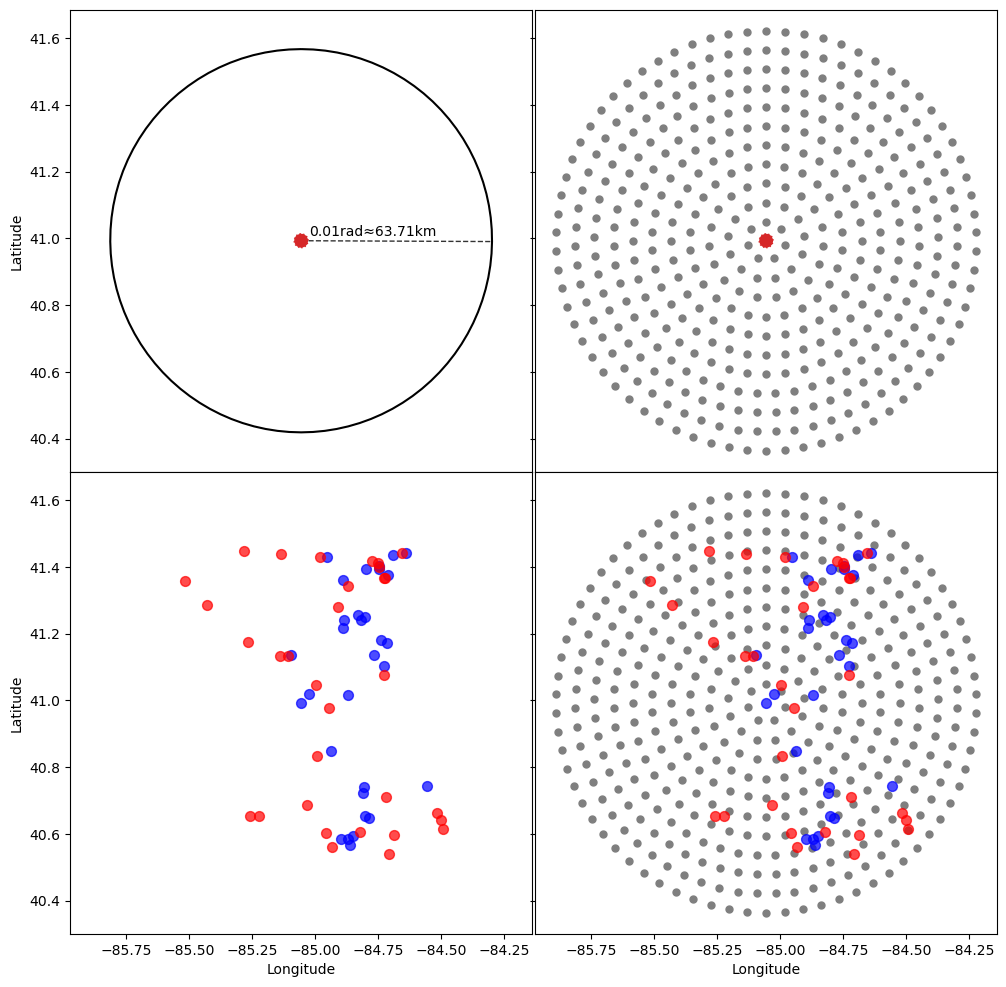

In [68]:
import random 
centeridx=random.randrange(len(data['coords']))
centeridx=438

fig = draw_ssi(
    data=data,
    centeridx=centeridx,
    partitioner=partitioner,
    radius=0.01,
    type='full'
    )
print(centeridx)
# plt.savefig('output.png')

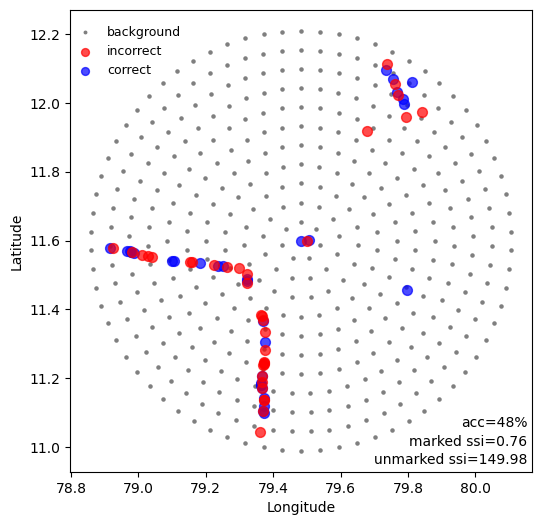

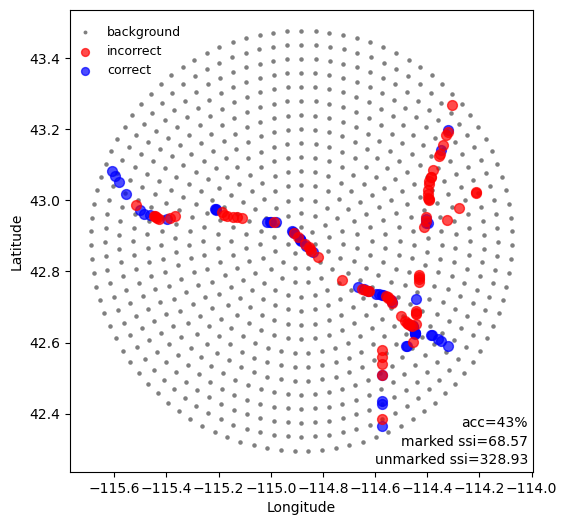

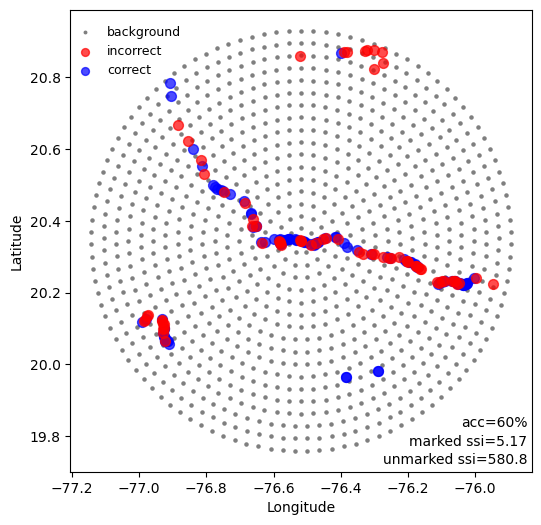

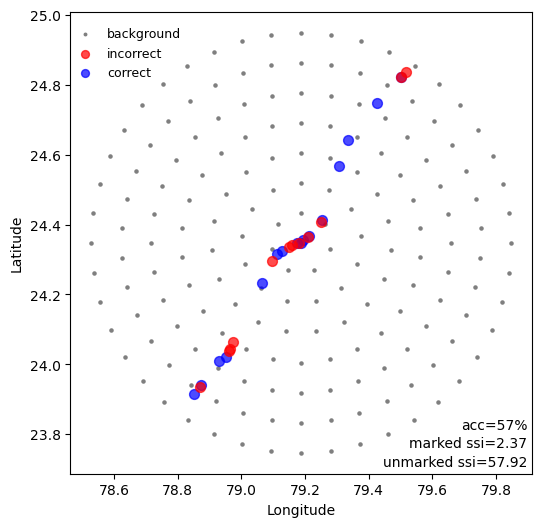

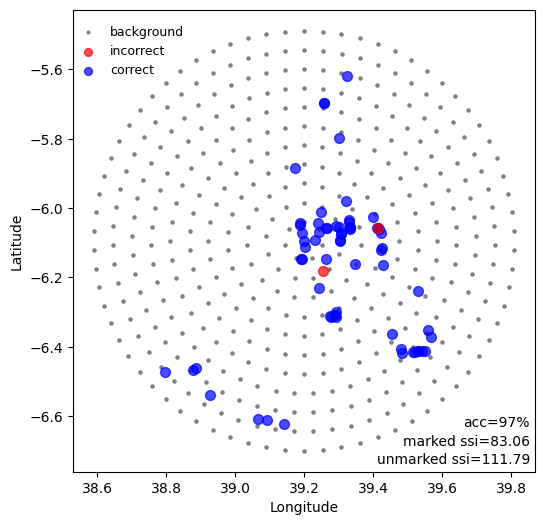

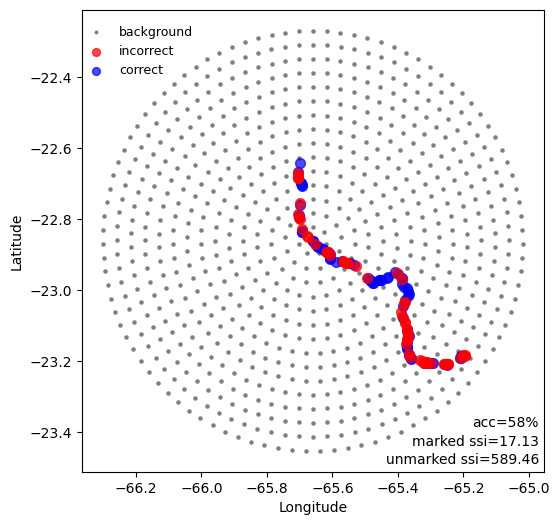

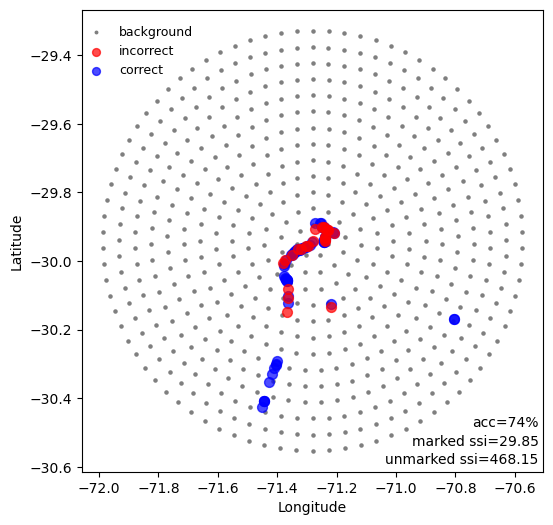

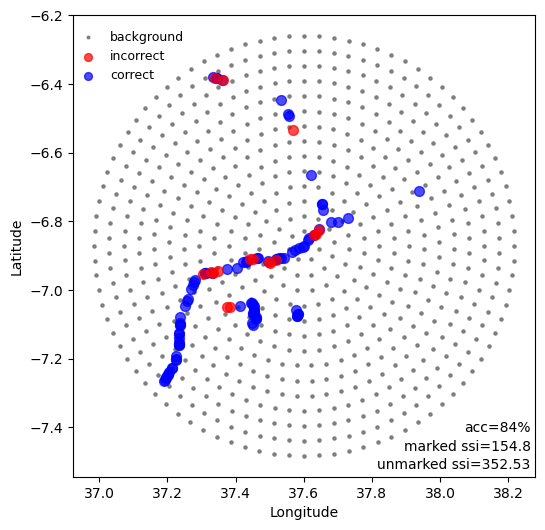

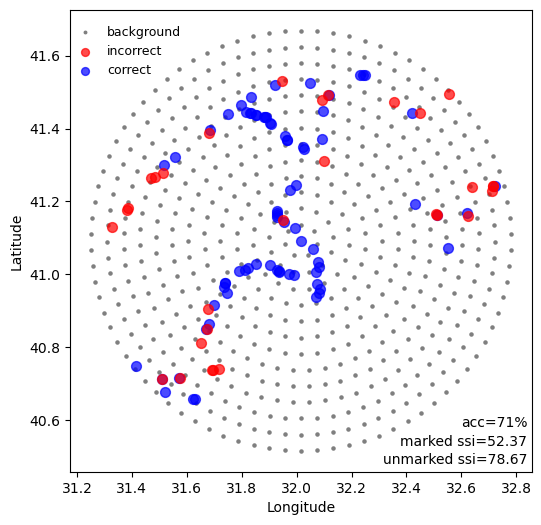

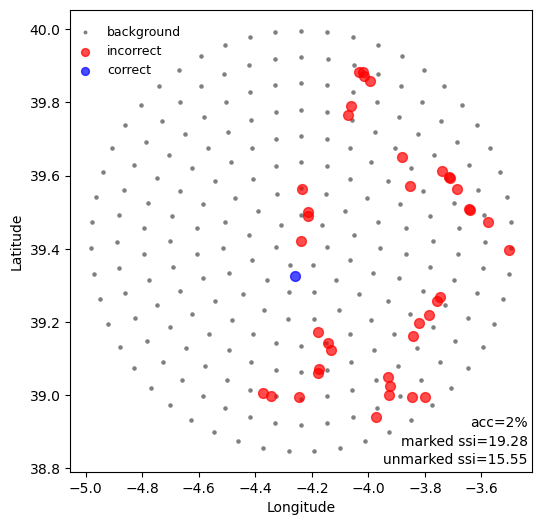

In [ ]:
import random

for i in range(10):
    a = draw_ssi(data=data, centeridx=random.randrange(len(data['coords'])), partitioner=partitioner, radius=0.01, type='single')

In [65]:
import pandas as pd


d = np.load("results/country_scale_0.01_radius_marked_ssi.npz")

accs = d['accs']
ssis = d['ssis']
coords = d['locs']

lats = coords[:,0] * (180 / np.pi)
lons = coords[:,1] * (180 / np.pi)

df = pd.DataFrame({
    'Latitude': lats,
    'Longitude': lons,
    'Accuracy': accs,
    'SSI': ssis
})

df.query('abs(Accuracy) < 0.02 & SSI < 10')

,Latitude,Longitude,Accuracy,SSI
438,40.993014,-85.056067,-0.015873,2.812053
665,-35.321995,173.328541,0.000000,1.888583
1360,-31.488267,-68.766490,0.016667,2.941467
1388,47.842615,-103.647714,0.014925,0.948243
1389,36.793490,14.504930,0.000000,9.087734
...,...,...,...,...
209563,8.532018,98.572883,0.016393,1.353487
209599,41.523299,-6.301540,0.000000,0.343063
209787,39.778989,15.796758,0.000000,0.476258
210019,-29.521944,30.242168,0.011765,0.156695


In [ ]:
# partitioner.kdt.query(partitioner.coords, k=100, return_distance=True)
idx=8
radius = 0.01
min_dist=0.0
print(partitioner.get_neighborhood(idx, radius))
print(partitioner.nbrs[idx, (partitioner.dists[idx] >= min_dist) & (partitioner.dists[idx] <= radius)])
mask = partitioner.nbrs[idx, (partitioner.dists[idx] >= min_dist) & (partitioner.dists[idx] <= radius)]
mask.nonzero()

i = 8
center = coords[i]
print(center)
presence_ids = partitioner.get_neighborhood(i, 0.01)
print(presence_ids)
presence_points = coords[presence_ids]
print(presence_points)
presence_values = values[presence_ids]
print(presence_values)

[     8 160636 104750  71481 172729  77885 175155  89524  79110  75239
  16383 132975 140660  97264  14512  75410 123569  47699  91237  48665
 158708 191954  89071 124827 131420  60860 188319 142401 141639 183641
 125150  90552 139335 132985  81430 147564 161529 105237 178876  95461
 201208  14064 109614 186985 116194  24370 190322  95155 147369 201266
  97570  21662 133164 107250 167756   9864  11617]
[     8 160636 104750  71481 172729  77885 175155  89524  79110  75239
  16383 132975 140660  97264  14512  75410 123569  47699  91237  48665
 158708 191954  89071 124827 131420  60860 188319 142401 141639 183641
 125150  90552 139335 132985  81430 147564 161529 105237 178876  95461
 201208  14064 109614 186985 116194  24370 190322  95155 147369 201266
  97570  21662 133164 107250 167756   9864  11617]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]),)

In [ ]:

## The index of the center point to evaluate.

locs, accs, ssis = [], [], []
marked_ssi = True
if marked_ssi:
    marked_string = "marked"
else:
    marked_string = "unmarked"
total = len(coords)

for idx in range(partitioner.N):
    center = coords[idx]

    ## Extract neighbood points.
    presence_idxs = partitioner.get_neighborhood(idx, radius)
    presence_points, presence_values = coords[presence_idxs], values[presence_idxs]

    avg_acc = np.mean(values[presence_idxs])

    ## Use automatic density estimation. Users can manually specify this hyperparameter.

    if marked_ssi:
        ## rp_ssi is the former relative geo-bias
        # marked ssi
        ssi = compute_marked_ssi(presence_points, presence_values, center, radius, density="auto", k=4)
    else:
        ## pnp_ssi is the former base geo-bias
        # unmarked_ssi
        ssi = compute_unmarked_ssi(presence_points, center, radius, density="auto", k=4)

    locs.append(center)
    accs.append(avg_acc)
    ssis.append(ssi)

    # print("Unmarked SSI Score: ", unmarked_ssi, "Marked SSI Score: ", marked_ssi)
    # print("Processed: ", idx, "Marked SSI Score: ", marked_ssi)

    print("Processed: {}/{}\r".format(idx, total), end="")

np.savez("results/{}_scale_{}_radius_{}_ssi".format(scale, radius, marked_string), locs=locs, accs=accs, ssis=ssis)


In [ ]:

## The index of the center point to evaluate.

locs, accs, marked_ssis, unmarked_ssis = [], [], [], []

marked = 'both' # can be 'unmarked' or 'marked' or 'both'
if marked == 'marked':
    marked_ssi = True
    unmarked_ssi = False
elif marked == 'unmarked':
    marked_ssi = False
    unmarked_ssi = True
elif marked == 'both':
    marked_ssi = True
    unmarked_ssi = True

total = len(coords)

for idx in range(partitioner.N):
    center = coords[idx]

    ## Extract neighbood points.
    presence_idxs = partitioner.get_neighborhood(idx, radius)
    presence_points, presence_values = coords[presence_idxs], values[presence_idxs]

    avg_acc = np.mean(values[presence_idxs])

    ## Use automatic density estimation. Users can manually specify this hyperparameter.

    if marked_ssi:
        ## rp_ssi is the former relative geo-bias
        # marked ssi
        ssi = compute_marked_ssi(presence_points, presence_values, center, radius, density="auto", k=4)
        marked_ssis.append(ssi)
    if unmarked_ssi:
        ## pnp_ssi is the former base geo-bias
        # unmarked_ssi
        ssi = compute_unmarked_ssi(presence_points, center, radius, density="auto", k=4)
        unmarked_ssis.append(ssi)

    locs.append(center)
    accs.append(avg_acc)

    # print("Unmarked SSI Score: ", unmarked_ssi, "Marked SSI Score: ", marked_ssi)
    # print("Processed: ", idx, "Marked SSI Score: ", marked_ssi)

    print("Processed: {}/{}\r".format(idx, total), end="")

np.savez("results/{}_scale_{}_radius_{}_ssi".format(scale, radius, marked_string), locs=locs, accs=accs, marked_ssis=marked_ssis, unmarked_ssis=unmarked_ssis)


Processed: 210121/210122

In [36]:
def load_ssi_results(path):
    if 'unmarked' in path:
        m = 'unmarked'
    else:
        m = 'marked'
    data = np.load(path)
    gdf = gpd.GeoDataFrame(geometry=[Point(np.rad2deg(p[1]), np.rad2deg(p[0])) for p in data['locs']], crs="EPSG:4326")
    gdf['accuracy'] = data['accs']
    gdf['accuracy_scaled'] = (gdf['accuracy'] + 1) / 2 # change from [-1,1] to [0,1] scale
    gdf[f'{m}_ssi'.format(m)] = data['ssis']
    return gdf

In [41]:
unmarked_path = 'results/country_scale_0.01_radius_unmarked_ssi.npz'
marked_path = 'results/country_scale_0.01_radius_marked_ssi.npz'

ssi_gdf = load_ssi_results(unmarked_path).merge(
    load_ssi_results(marked_path)[['geometry', 'marked_ssi']],
    on='geometry'
    )
ssi_gdf

AttributeError: 'NoneType' object has no attribute 'copy'

,geometry,accuracy,accuracy_scaled,unmarked_ssi,marked_ssi
0,POINT (-126.74071 54.36878),0.464481,0.732240,589.461784,114.993256
1,POINT (-109.74177 48.61917),-0.500000,0.250000,589.461784,262.713603
2,POINT (110.42196 1.45881),0.787755,0.893878,589.461784,314.959409
3,POINT (15.84863 5.85432),0.970000,0.985000,589.461784,589.461784
4,POINT (31.79542 -25.03171),-0.258065,0.370968,104.355211,8.047787
...,...,...,...,...,...
210117,POINT (72.83268 20.36015),0.111111,0.555556,32.406331,19.478121
210118,POINT (104.93044 11.69605),-0.445783,0.277108,304.070587,45.621722
210119,POINT (-105.96881 32.87166),0.027027,0.513514,80.685141,3.032444
210120,POINT (-99.01004 32.91904),-0.928571,0.035714,23.104885,14.990561


<Axes: >

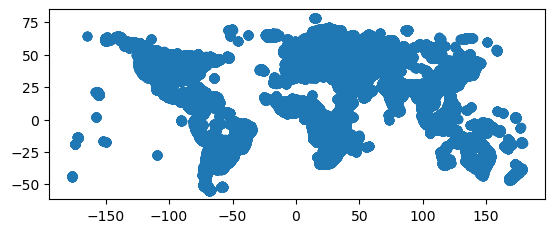

In [43]:
ssi_gdf.plot()